In [61]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
import renders as rs
import matplotlib.pyplot as plt
import itertools
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.decomposition import PCA



# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("Wholesale customers data.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print ("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print ("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


In [5]:
# Display a description of the dataset
stats = data.describe()
stats

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

In [6]:
#sampling  a few customers to see how they differ
# Using data.loc to filter a pandas DataFrame
data.loc[[100, 200, 300],:]

Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen
100  11594   7779    12144    3252              8035        3029
200   3067  13240    23127    3941              9959         731
300  16448   6243     6360     824              2662        2005

In [10]:
indices = [43, 12, 39]

# Create a DataFrame of the chosen samples
# .reset_index(drop = True) resets the index from 0, 1 and 2 instead of 100, 200 and 300 
samples = pd.DataFrame(data.loc[indices], columns = data.columns).reset_index(drop = True)
print ("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0    630  11095    23998     787              9529          72
1  31714  12319    11757     287              3881        2931
2  56159    555      902   10002               212        2916

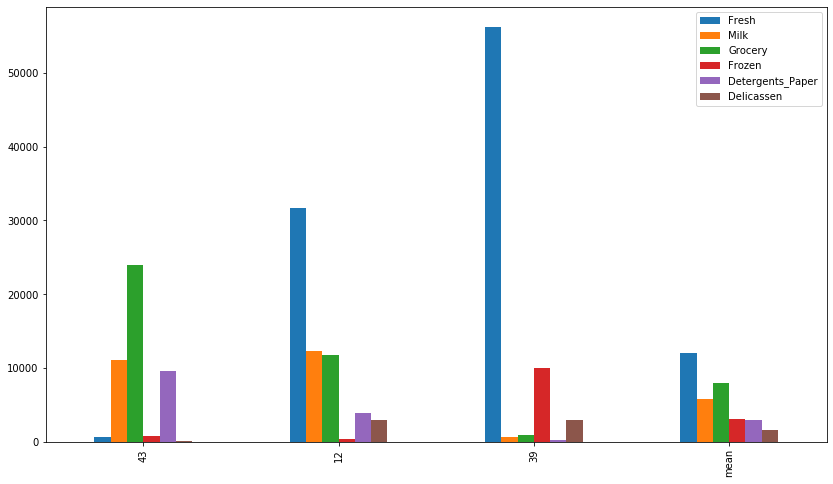

In [12]:
#comparison of samples and means

# Get the means 
mean_data = data.describe().loc['mean', :]

# Append means to the samples' data
samples_bar = samples.append(mean_data)

# Construct indices
samples_bar.index = indices + ['mean']

# Plot bar plot
samples_bar.plot(kind='bar', figsize=(14,8))

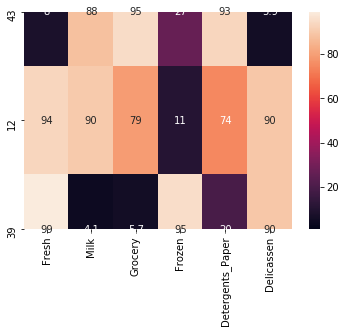

In [19]:
#comparing samples percentile
# First, calculate the percentile ranks of the whole dataset.
percentiles = data.rank(pct=True)

# Then, round it up, and multiply by 100
percentiles = 100*percentiles.round(decimals=3)

# Select the indices you chose from the percentiles dataframe
percentiles = percentiles.iloc[indices]

# Now, create the heat map using the seaborn library
sns.heatmap(percentiles, 
            vmin=1, 
            vmax=99, 
            annot=True
           )

In [21]:
#Considering the total purchase cost of each product category and the statistical description of the dataset above
#the three samples could represent the following customers:
#Index 0: Coffee Cafe
#Low spending on "Fresh", "Frozen" and "Delicatessen". Majority of spending on "Grocery", "Milk" and "Detergents_Paper".
#Index 1: Upscale Restaurant with fresh food
# Low spending on "Frozen". Majority of spending is a mix of "Fresh", "Milk, and "Grocery"
#Index 2: Fresh Food Retailer
#Majority of spending is on "Fresh" goods with little spending on everything else except on "Frozen".

# Feature relevance

In [23]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [25]:
#drop one variable one by one and allow the regressor to predict the outcome of the dropped variable/feature
#based on the remaining one
dep_vars = list(data.columns)

# Create loop to test each feature as a dependent variable
for var in dep_vars:

    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data.drop([var], axis = 1)

    # Create feature Series (Vector)
    new_feature = pd.DataFrame(data.loc[:, var])

    #Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data, new_feature, test_size=0.25, random_state=42)

    # Create a decision tree regressor and fit it to the training set
    # Instantiate
    dtr = DecisionTreeRegressor(random_state=42)
    # Fit
    dtr.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    # Returns R^2
    score = dtr.score(X_test, y_test)
    print('R2 score for {} as dependent variable: {}'.format(var, score))
    
    #The coefficient of determination, R^2, is scored between 0 and 1, with 1 being a perfect fit. 
    #A negative R^2 implies the model fails to fit the data.
    
#"Fresh", "Frozen" and "Delicatessen" as dependent variables have negative R2 scores. -> they are necessary for 
#identifying customers' spending habits because the remaining features cannot explain the variation in them.
#"Milk" and "Detergents_Paper" have very low R2 scores.-> necessary for identifying customers' spending habits.
#Grocery has a very high R2 score, therefore it might not be important in predicting customer habits


R2 score for Fresh as dependent variable: -0.38574971020407384
R2 score for Milk as dependent variable: 0.15627539501732116
R2 score for Grocery as dependent variable: 0.6818840085440834
R2 score for Frozen as dependent variable: -0.21013589012491396
R2 score for Detergents_Paper as dependent variable: 0.27166698062685013
R2 score for Delicassen as dependent variable: -2.254711537203931


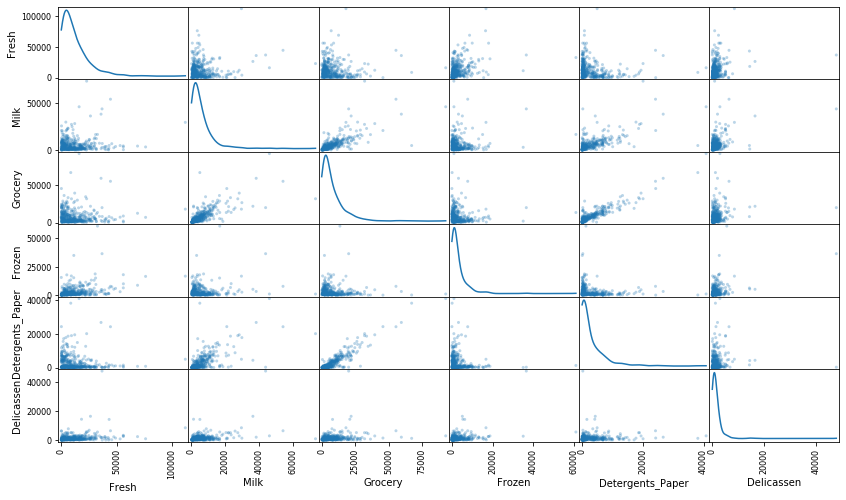

In [30]:
#feature distribution
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

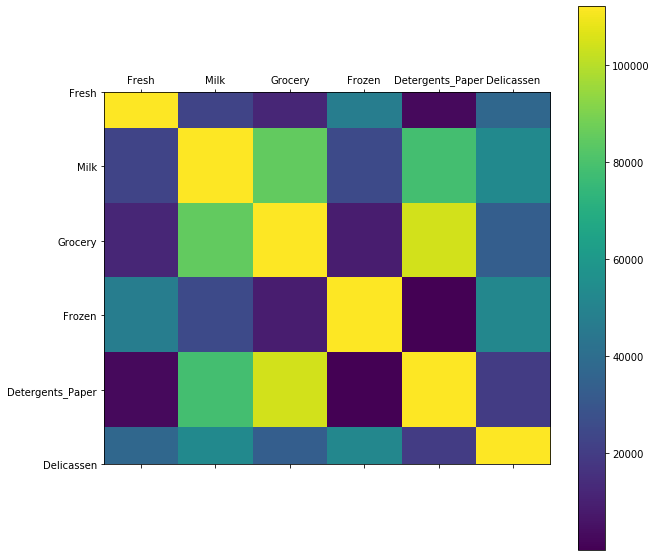

In [29]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, interpolation='nearest')
    ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);


plot_corr(data)

In [31]:
#The follow pairs of features seem to have some correlation as observed from the scatter plot showing a linear 
#trend and the correlation plot showing a high correlation between the two features. 
# strongest to weakest correlation:Grocery and Detergents_Paper, Grocery and Milk, Detergents_Paper and Milk (not too strong).
#Thus, Grocery may not be necessary for identifying customers' spending habits.

#The data are not normally distributed due to the presence of many outliers.most are skewed to the left .
#--> normalization is required to make the data features normally distributed as clustering algorithms require them to be
#normally distributed.

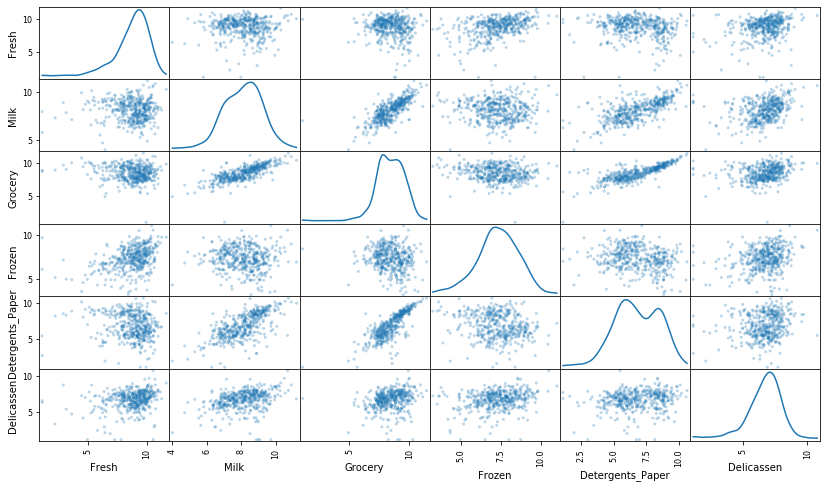

In [33]:
#feature scaling
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [34]:
#peak at the log-transformed sample
display(log_samples)

Fresh      Milk    Grocery    Frozen  Detergents_Paper  Delicassen
0   6.445720  9.314250  10.085726  6.668228          9.162095    4.276666
1  10.364514  9.418898   9.372204  5.659482          8.263848    7.983099
2  10.935942  6.318968   6.804615  9.210540          5.356586    7.977968

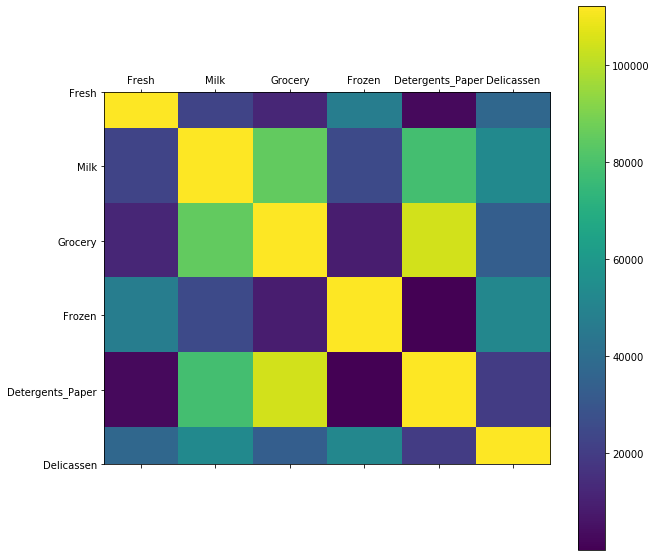

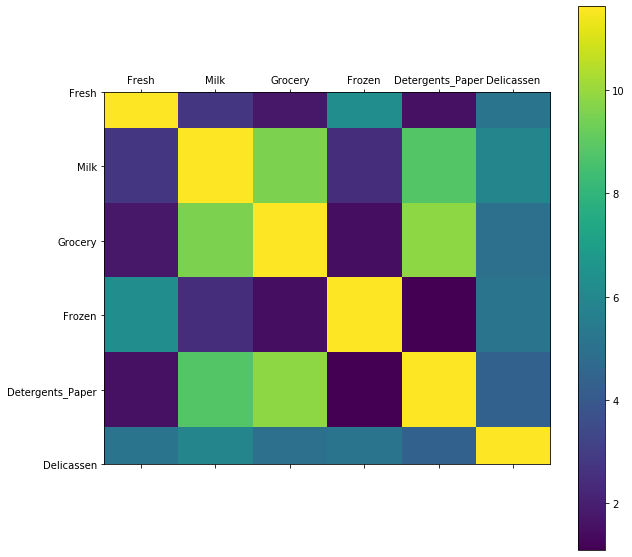

In [35]:
plot_corr(data)
plot_corr(log_data)

In [37]:
#outlier detection
#Detecting outliers in the data is extremely important in the data preprocessing step of any analysis.
#The presence of outliers can often skew results which take into consideration these data points. 
#There are many "rules of thumb" for what constitutes an outlier in a dataset. 
#Here, we will use Tukey's Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile 
#range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature 
#is considered abnormal.

In [40]:
# Select the indices for data points to remove
outliers_lst  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.columns:
    #Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data.loc[:, feature], 25)

    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data.loc[:, feature], 75)

    #Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    # Display the outliers
    print ("Data points considered outliers for the feature '{}':".format(feature))

    # find any points outside of Q1 - step and Q3 + step
    outliers_rows = log_data.loc[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step)), :]
    # display(outliers_rows)

    outliers_lst.append(list(outliers_rows.index))

outliers = list(itertools.chain.from_iterable(outliers_lst))

# List of unique outliers -> set()
uniq_outliers = list(set(outliers))

# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

print ('Outliers list:\n', uniq_outliers)
print ('Length of outliers list:\n', len(uniq_outliers))

print ('Duplicate list:\n', dup_outliers)
print ('Length of duplicates list:\n', len(dup_outliers))

# Remove duplicate outliers
good_data = log_data.drop(log_data.index[dup_outliers]).reset_index(drop = True)

# Original Data 
print ('Original shape of data:\n', data.shape)
# Processed Data
print ('New shape of data:\n', good_data.shape)

Data points considered outliers for the feature 'Fresh':
Data points considered outliers for the feature 'Milk':
Data points considered outliers for the feature 'Grocery':
Data points considered outliers for the feature 'Frozen':
Data points considered outliers for the feature 'Detergents_Paper':
Data points considered outliers for the feature 'Delicassen':
Outliers list:
 [128, 264, 137, 142, 145, 154, 412, 285, 161, 289, 420, 38, 171, 429, 175, 304, 305, 439, 183, 57, 184, 187, 65, 66, 193, 325, 75, 203, 81, 338, 86, 343, 218, 95, 96, 353, 98, 355, 356, 357, 233, 109]
Length of outliers list:
 42
Duplicate list:
 [128, 65, 66, 75, 154]
Length of duplicates list:
 5
Original shape of data:
 (440, 6)
New shape of data:
 (435, 6)


# feature transformation

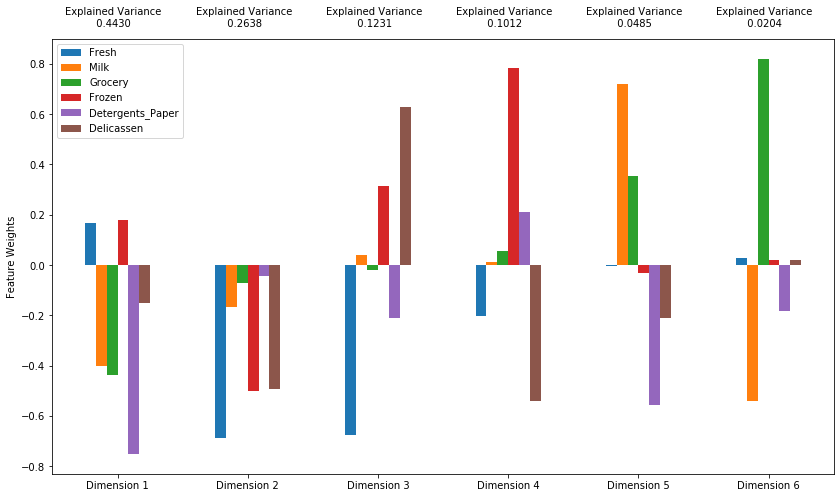

In [47]:
#PCA -> calculates the dimensions which best maximize variance, to find which compound combinations of features 
#best describe customers.

# Apply PCA by fitting the good data with the same number of dimensions as features
# Instantiate
pca = PCA(n_components=6)
# Fit
pca.fit(good_data)

# Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

In [50]:
# DataFrame of results
display(pca_results)

# DataFrame
display(type(pca_results))

# Cumulative explained variance should add to 1
display(pca_results['Explained Variance'].cumsum())

Explained Variance   Fresh    Milk  Grocery  Frozen  \
Dimension 1              0.4430  0.1675 -0.4014  -0.4381  0.1782   
Dimension 2              0.2638 -0.6859 -0.1672  -0.0707 -0.5005   
Dimension 3              0.1231 -0.6774  0.0402  -0.0195  0.3150   
Dimension 4              0.1012 -0.2043  0.0128   0.0557  0.7854   
Dimension 5              0.0485 -0.0026  0.7192   0.3554 -0.0331   
Dimension 6              0.0204  0.0292 -0.5402   0.8205  0.0205   

             Detergents_Paper  Delicassen  
Dimension 1           -0.7514     -0.1499  
Dimension 2           -0.0424     -0.4941  
Dimension 3           -0.2117      0.6286  
Dimension 4            0.2096     -0.5423  
Dimension 5           -0.5582     -0.2092  
Dimension 6           -0.1824      0.0197

pandas.core.frame.DataFrame

Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64

In [51]:
#the first four dimensions best represent in terms of customer spending.
#A positive increase in a specific dimension corresponds with an increase of the positive-weighted features and
#a decrease of the negative-weighted features. The rate of increase or decrease is based on the indivdual feature weights.

#for dimension 

#70.68% of the variance in the data is explained by the first and second principal components.
#93.11% of the variance in the data is explained by the first four principal components.
#Components breakdown:
#The first principal component (PC1):
#"Milk", "Grocery" and "Detergents_Paper" negatively contribute to PC1, 
#while fresh and frozen contribute positively ---> clients selecting these have a lower preff for Milk, groceries and Paper

#The second principal component (PC2):
# Grocery and Paper have a less negative (close to 0) contribution, thus people preffering these spend less on 
# "Fresh", "Frozen" and "Delicatessen" spending.

#The third principal component (PC3):
#stron positive score for delicassen and frozen, so these clients prefer fresh and detergent less 


# and this i s where by using these dimensions we could try to make sense of the cohorts. 

#this is where the PCA analysis stops

In [52]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
0      -3.1072       2.7017      -0.6386       1.8708       0.6452   
1      -2.2406      -1.2419      -1.0729      -1.9589       0.2160   
2       3.0426      -2.5854       0.1965      -0.0757      -1.4213   

   Dimension 6  
0       0.1333  
1      -0.1782  
2       0.0093

# Dimensionality reduction

In [53]:
#When using principal component analysis, one of the main goals is to reduce the dimensionality of the data —
#in effect, reducing the complexity of the problem. 
#Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is 
#being explained. Because of this, the cumulative explained variance ratio is extremely important for knowing how
#many dimensions are necessary for the problem.
#Additionally, if a signifiant amount of variance is explained by only two or three dimensions, 
#the reduced data can be visualized afterwards.

In [65]:
# PCA by fitting the good data with only two dimensions
# Instantiate
pca = PCA(n_components=3)
pca.fit(good_data)

#Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

#Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])
reduced_data

Dimension 1  Dimension 2  Dimension 3
0      -1.757983     0.009711    -0.959029
1      -1.788665    -0.812251     0.231474
2      -1.883353    -1.599135     1.320393
3       1.155265    -1.405201     0.542235
4      -0.784786    -2.394294     0.479768
..           ...          ...          ...
430     0.644850    -2.858285     0.637678
431     3.184831    -1.944772     0.267656
432    -3.742535    -0.856146    -0.988483
433     1.669147    -0.397968     0.516105
434     0.739011     3.691448    -2.033477

[435 rows x 3 columns]

In [66]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2', 'Dimension 3']))

Dimension 1  Dimension 2  Dimension 3
0      -3.1072       2.7017      -0.6386
1      -2.2406      -1.2419      -1.0729
2       3.0426      -2.5854       0.1965

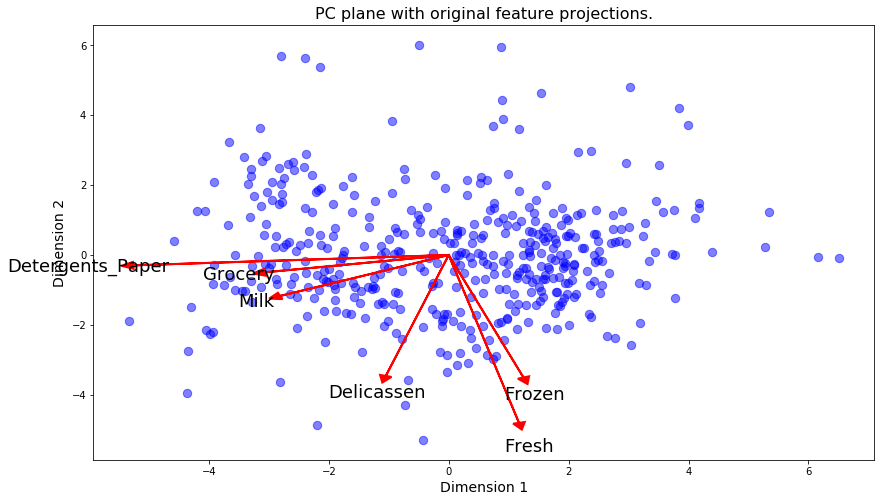

In [67]:
# Create a biplot
def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute
    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

biplot(good_data, reduced_data, pca)


#Once we have the original feature projections (in red), it is easier to interpret the relative position of each 
#data point in the scatterplot. 

# Clustering

In [68]:
#What are the advantages to using a K-Means clustering algorithm? 
#K-Means Clustering Algorithm - points in the same cluster have shorter distance than points from other clusters.
#The goal is to minimize the distance within the same cluster.
#Points belong explicitly to clusters
#Disadvantages : - 1. It may converge to a local optima depending on your initialization of clusters.(We can initialize multiple times.
#                - 2. It may be computationally expensive to compute Euclidean distances.(batch K-means to solve this)
#                - 3. It is susceptible to outliers. (pre-process our data to exclude outliers to solve this)

#What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
# There is no definite assignment of points to clusters.vPoints have probabilities of belonging to clusters.
# There is greater flexibility due to clusters having unconstrained covariances. It allows mixed memberships.
#Disadvantages : - 1. It may converge to a local optima depending on your initialization of clusters. (We can initialize multiple times
#                - 2. difficult and complicated model to interpret.


In [69]:
#When the number of clusters is not known a priori, there is no guarantee that a given number of clusters best segments 
#the data, since it is unclear what structure exists in the data — if any. 
#However, we can quantify the "goodness" of a clustering by calculating each data point's silhouette coefficient. 
#The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). 
#Calculating the mean silhouette coefficient provides for a simple scoring method of a given clustering.

In [72]:
# Imports
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [73]:
# Create range of clusters 
range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [76]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = mixture.GaussianMixture(n_components=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))
    
Best score is for k = 2

For n_clusters = 2. The average silhouette_score is : 0.28083688604371093
For n_clusters = 3. The average silhouette_score is : 0.19944817222307107
For n_clusters = 4. The average silhouette_score is : 0.20660641176844702
For n_clusters = 5. The average silhouette_score is : 0.16743917398426658
For n_clusters = 6. The average silhouette_score is : 0.18668595908181643
For n_clusters = 7. The average silhouette_score is : 0.16834425055263363
For n_clusters = 8. The average silhouette_score is : 0.1655662808089305
For n_clusters = 9. The average silhouette_score is : 0.1647577726785893
For n_clusters = 10. The average silhouette_score is : 0.16993028708417696


In [84]:
# Loop through clusters
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))
    
#best score is for k = 2

For n_clusters = 2. The average silhouette_score is : 0.36879128989640114
For n_clusters = 3. The average silhouette_score is : 0.33098351812167626
For n_clusters = 4. The average silhouette_score is : 0.25383668331263726
For n_clusters = 5. The average silhouette_score is : 0.2772500548449863
For n_clusters = 6. The average silhouette_score is : 0.2843118409604045
For n_clusters = 7. The average silhouette_score is : 0.2644836017520532
For n_clusters = 8. The average silhouette_score is : 0.2759338202061456
For n_clusters = 9. The average silhouette_score is : 0.26275255278370363
For n_clusters = 10. The average silhouette_score is : 0.2666221882979842


In [85]:
#distance metric 
#The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample
# This is Euclidean for KMeans and Mahalanobis for general GMM.

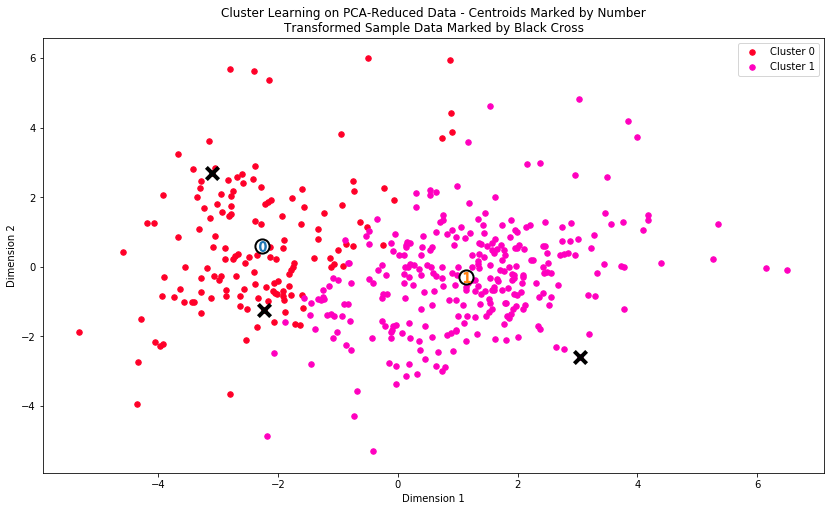

In [87]:
# Extra code because we ran a loop on top and this resets to what we want
clusterer = mixture.GaussianMixture(n_components=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

In [89]:
#re transform data back to the usual unit of measurement
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.columns)
true_centers.index = segments
print("The true centers are printed below")
display(true_centers)

The true centers are printed below


Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicassen
Segment 0  3257.0  7568.0  12261.0   713.0            4972.0       762.0
Segment 1  8997.0  2271.0   2936.0  2210.0             382.0       832.0

In [91]:
#Consider the total purchase cost of each product category for the representative data points above, 
#and reference the statistical description of the dataset at the beginning of this project. 
#What set of establishments could each of the customer segments represent?
#Hint: A customer who is assigned to 'Cluster X' should best identify with the establishments represented by 
#the feature set of 'Segment X'.

In [92]:
# Clusters' deviation from median
display(true_centers - data.median())

# Clusters' deviation from mean
# As you can see, this is not a meaningful comparison for Segment 1 where everything is negative
display(true_centers - data.mean())

Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicassen
Segment 0 -5247.0  3941.0   7505.5  -813.0            4155.5      -203.5
Segment 1   493.0 -1356.0  -1819.5   684.0            -434.5      -133.5

Fresh         Milk      Grocery       Frozen  \
Segment 0 -8743.297727  1771.734091  4309.722727 -2358.931818   
Segment 1 -3003.297727 -3525.265909 -5015.277273  -861.931818   

           Detergents_Paper  Delicassen  
Segment 0       2090.506818 -762.870455  
Segment 1      -2499.493182 -692.870455

In [93]:
#We will be using deviations from the median, with reference to the statistical description of the dataset at 
#the beginning of this project, since mean is sensitive to outliers and would not yield meaningful comparisons.
#Segment 0:
#Establishments in this segment have above median spending on "Milk", "Grocery" and "Detergents_Paper".
#This could represent restaurants and cafes.
#Segment 1:
#Establishments in this segment have above median spending on "Fresh" and "Frozen".
#This could represent typical retailers such as markets specializing in fresh and frozen food.
#This is typical in seafood or meat markets.

In [94]:
#For each sample point, which customer segment best represents it? 
#Are the predictions for each sample point consistent with this?

In [97]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print ("Sample point", i, "predicted to be in Cluster", pred)
samples

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0    630  11095    23998     787              9529          72
1  31714  12319    11757     287              3881        2931
2  56159    555      902   10002               212        2916

In [99]:
dup_outliers

[128, 65, 66, 75, 154]

In [100]:
reduced_data

Dimension 1  Dimension 2  Dimension 3
0      -1.757983     0.009711    -0.959029
1      -1.788665    -0.812251     0.231474
2      -1.883353    -1.599135     1.320393
3       1.155265    -1.405201     0.542235
4      -0.784786    -2.394294     0.479768
..           ...          ...          ...
430     0.644850    -2.858285     0.637678
431     3.184831    -1.944772     0.267656
432    -3.742535    -0.856146    -0.988483
433     1.669147    -0.397968     0.516105
434     0.739011     3.691448    -2.033477

[435 rows x 3 columns]

In [101]:
pca_samples

array([[-3.10719315,  2.70167561, -0.6385771 ],
       [-2.24063428, -1.24187413, -1.07293782],
       [ 3.04257605, -2.58536241,  0.19648589]])